In [42]:
import numpy as np 
import pandas as pd 
import os
cnt=0
for dirname, _, filenames in os.walk(r'C:\Users\saich\Downloads\Projects\MalwareDetection_CNN\dataset_9010'):
    for filename in filenames:
        cnt+=1
        #print(os.path.join(dirname, filename))
print(cnt)

9339


In [43]:
import matplotlib.pyplot as plt
import os
import keras
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten , BatchNormalization
from keras.layers import Conv2D, MaxPooling2D , AveragePooling2D,GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [63]:
train=r"C:\Users\saich\Downloads\dataset_9010\dataset_9010\malimg_dataset\train"
val=r'C:\Users\saich\Downloads\dataset_9010\dataset_9010\malimg_dataset\Validation'
batch_size=32
IMAGE_SIZE = [150, 150]

In [64]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train,
    seed=123,
    shuffle=True,
    image_size=(150,150),
    batch_size=batch_size
)

Found 8404 files belonging to 25 classes.


In [65]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    seed=123,
    shuffle=True,
    image_size=(150,150),
    batch_size=batch_size
)

Found 935 files belonging to 25 classes.


In [66]:
class_names=dataset.class_names

**Visualisation of some pictures in a batch**

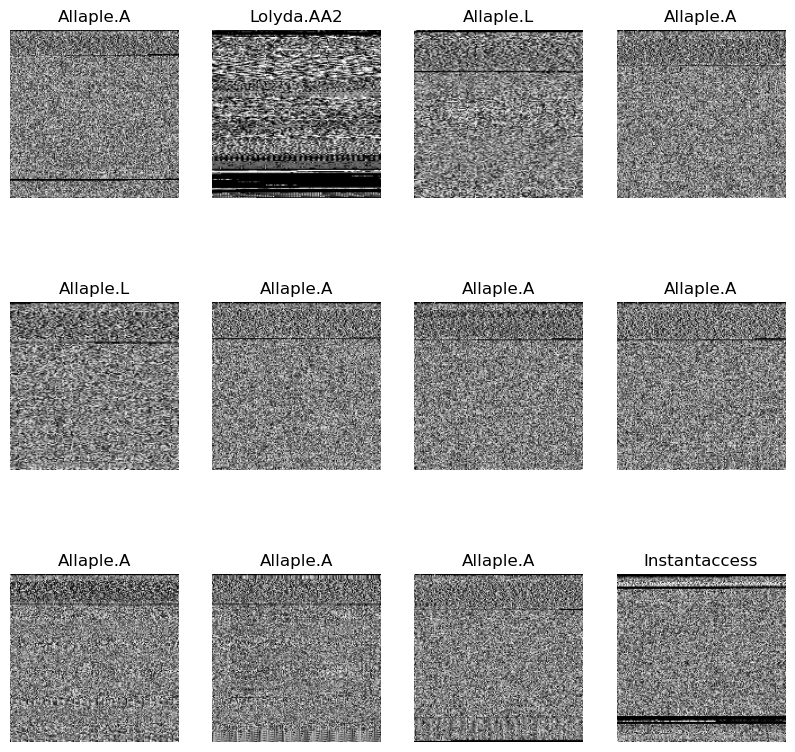

In [67]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Splitting Data to train and test

In [68]:
def get_dataset_partitions_tf(ds, train_split=0.9, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)    
    test_ds = ds.skip(train_size).take(test_size)
    
    
    return train_ds, test_ds

In [69]:
train_ds, test_ds = get_dataset_partitions_tf(dataset)

In [70]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [73]:
def malware_model(width , height):
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(width, height, 3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    
    Malware_model.add(Dense(25, activation='softmax'))
    Malware_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

#  **Without Scaling Model**

In [74]:
model=malware_model(150 , 150)

In [75]:
model_fit = model.fit(train_ds, epochs=20 ,batch_size = batch_size ,validation_data=val_ds, verbose =1)

Epoch 1/20
236/236 [==============================] - 112s 373ms/step - loss: 7.9281 - accuracy: 0.6556 - val_loss: 0.8486 - val_accuracy: 0.7925
Epoch 2/20
236/236 [==============================] - 82s 347ms/step - loss: 0.5065 - accuracy: 0.8866 - val_loss: 0.4193 - val_accuracy: 0.8909
Epoch 3/20
236/236 [==============================] - 79s 335ms/step - loss: 0.4390 - accuracy: 0.9069 - val_loss: 0.3852 - val_accuracy: 0.8706
Epoch 4/20
236/236 [==============================] - 78s 329ms/step - loss: 0.2619 - accuracy: 0.9324 - val_loss: 0.2854 - val_accuracy: 0.9166
Epoch 5/20
236/236 [==============================] - 77s 325ms/step - loss: 0.2073 - accuracy: 0.9495 - val_loss: 0.3320 - val_accuracy: 0.9102
Epoch 6/20
236/236 [==============================] - 84s 356ms/step - loss: 0.1521 - accuracy: 0.9580 - val_loss: 0.4044 - val_accuracy: 0.9091
Epoch 7/20
236/236 [==============================] - 196s 833ms/step - loss: 0.1570 - accuracy: 0.9610 - val_loss: 0.3156 - val_

In [76]:
model.evaluate(test_ds)

26/26 [==============================] - 12s 72ms/step - loss: 0.0139 - accuracy: 0.9952


[0.01388340350240469, 0.995192289352417]

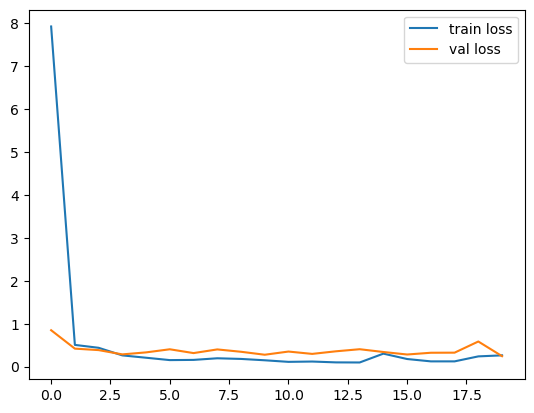

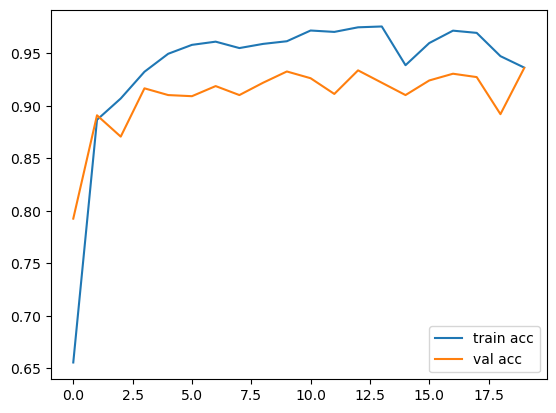

In [77]:
# plot the loss
plt.plot(model_fit.history['loss'], label='train loss')
plt.plot(model_fit.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss.jpg',format='jpg')

plt.close()
# plot the accuracy
plt.plot(model_fit.history['accuracy'], label='train acc')
plt.plot(model_fit.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc.jpg',format="jpg")

plt.close()

# ****Saving the Model****

In [78]:
model.save("./Malimg_model.h5")

C:\Users\saich\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# ****Model with Scaling****

In [79]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(150, 150),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [80]:
def malware_model(width , height):
    Malware_model = Sequential()
    
    Malware_model.add(resize_and_rescale)
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape = (batch_size, width, height, 3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    
    Malware_model.add(Dense(25, activation='softmax'))
    Malware_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [81]:
EPOCH = 100

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=4, verbose=1,  factor=0.4, min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=8, mode='auto', restore_best_weights=True)

In [82]:
model=malware_model(150 , 150)
model_fit = model.fit(train_ds, epochs=EPOCH ,batch_size = batch_size ,validation_data=val_ds, verbose =1,callbacks=[early_stop,lr_reduction])

Epoch 1/100
236/236 [==============================] - 94s 392ms/step - loss: 1.0088 - accuracy: 0.7316 - val_loss: 0.4281 - val_accuracy: 0.8834 - lr: 0.0010
Epoch 2/100
236/236 [==============================] - 87s 366ms/step - loss: 0.3335 - accuracy: 0.8991 - val_loss: 0.2076 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 3/100
236/236 [==============================] - 86s 364ms/step - loss: 0.2497 - accuracy: 0.9215 - val_loss: 0.2049 - val_accuracy: 0.9198 - lr: 0.0010
Epoch 4/100
236/236 [==============================] - 85s 361ms/step - loss: 0.2126 - accuracy: 0.9325 - val_loss: 0.1821 - val_accuracy: 0.9230 - lr: 0.0010
Epoch 5/100
236/236 [==============================] - 78s 328ms/step - loss: 0.1873 - accuracy: 0.9408 - val_loss: 0.1596 - val_accuracy: 0.9305 - lr: 0.0010
Epoch 6/100
236/236 [==============================] - 77s 326ms/step - loss: 0.1668 - accuracy: 0.9448 - val_loss: 0.1539 - val_accuracy: 0.9316 - lr: 0.0010
Epoch 7/100
236/236 [=========================

In [83]:
model.evaluate(test_ds)

26/26 [==============================] - 3s 99ms/step - loss: 0.0247 - accuracy: 0.9976


[0.02472654916346073, 0.9975961446762085]

In [84]:
model.save("./Best_Model.h5")

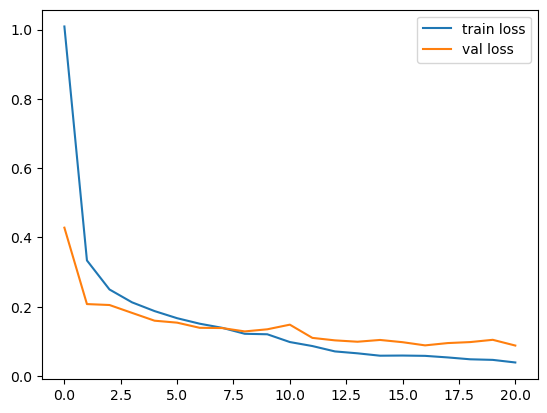

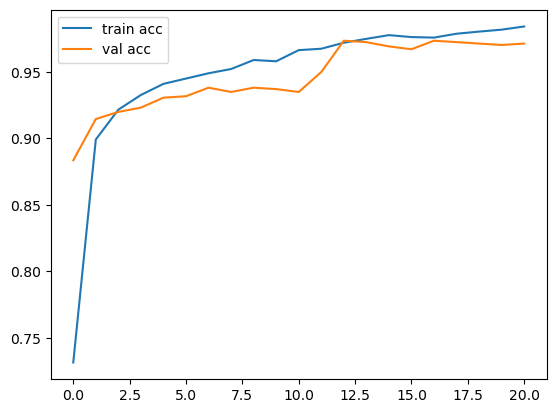

In [85]:
# plot the loss
plt.plot(model_fit.history['loss'], label='train loss')
plt.plot(model_fit.history['val_loss'], label='val loss')
plt.legend()
plt.show()


plt.close()
# plot the accuracy
plt.plot(model_fit.history['accuracy'], label='train acc')
plt.plot(model_fit.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


plt.close()

#  **Without Scaling Is The Best Model**

first image to predict
actual label: Lolyda.AA1
1/1 [==============================] - 1s 643ms/step
predicted label: Lolyda.AA1


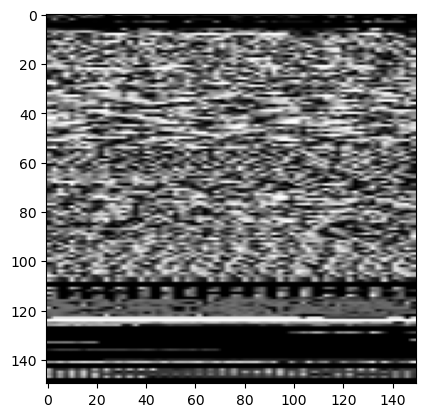

In [86]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [87]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


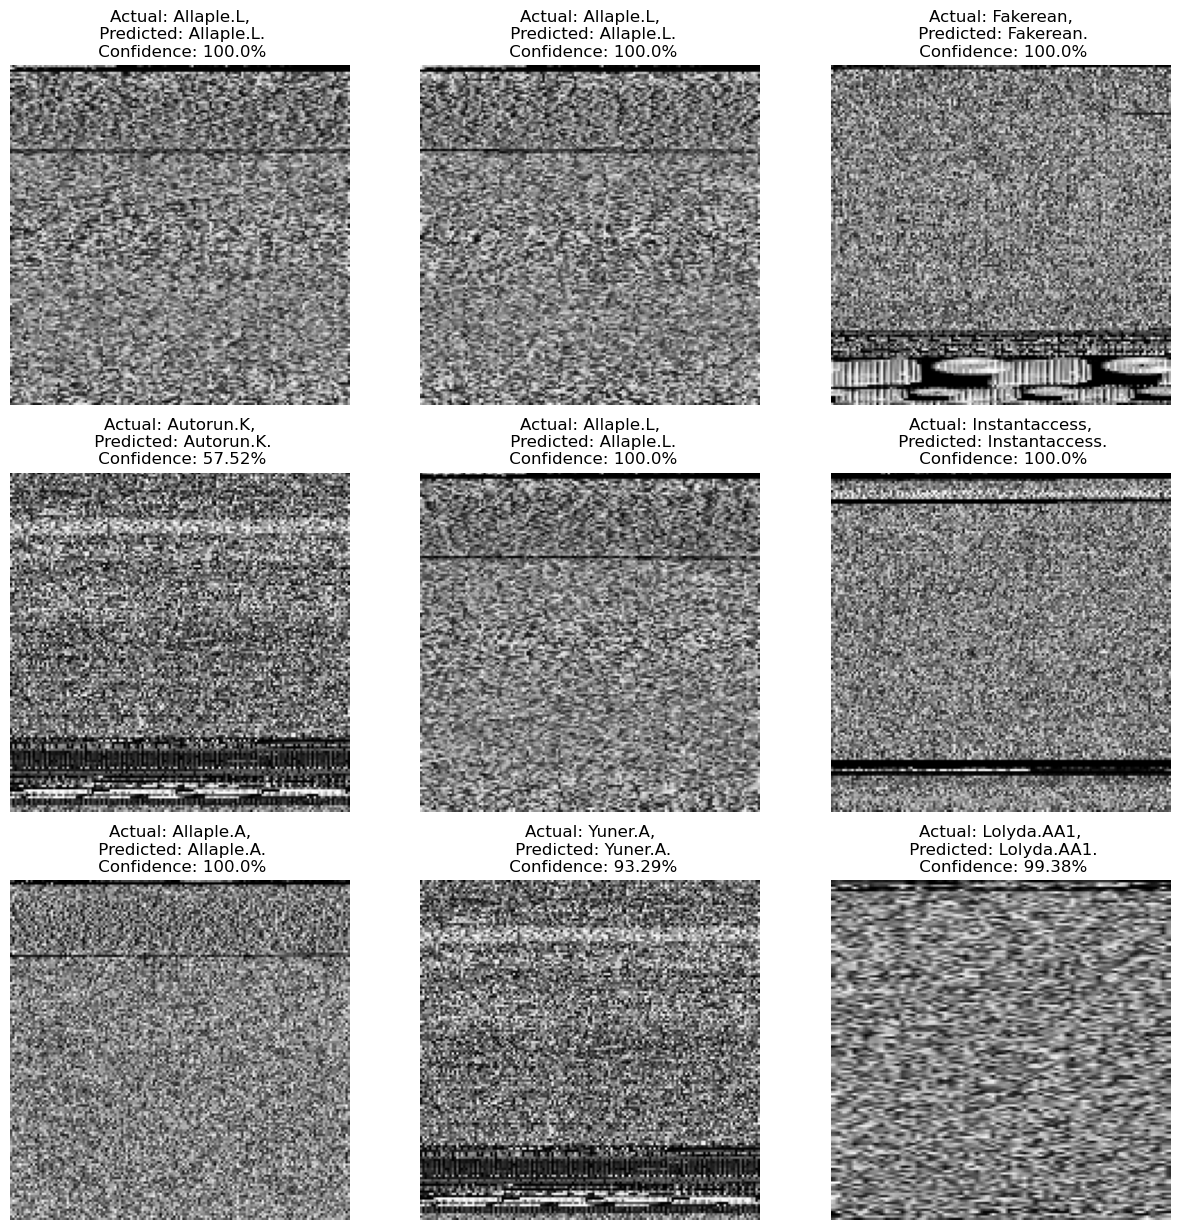

In [95]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [96]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 30)      840       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 30)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 15)        4065      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 15)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 36, 36, 15)       

In [97]:
from keras.models import load_model
model=load_model("./Best_Model.h5")

Predicting a random image

In [100]:
from keras.preprocessing import image
img_path=r"C:\Users\saich\Downloads\dataset_9010\dataset_9010\malimg_dataset\validation\Yuner.A\00a2b177c3ea7b2072fdfd8ebcbed0b6.png"
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
                                      # imshow expects values in the range [0, 1]

pred=model.predict(img_tensor)
print(class_names[np.argmax(pred)])

1/1 [==============================] - 0s 75ms/step
VB.AT
